In [310]:
from collections import Counter
from functools import reduce
from helpers import tokenize_from_ranks
import numpy as np

import ray

2025-01-06 09:54:58,610	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def find_most_frequent_long_consecutive2(docs,max_length,full_word_bias_factor=3,min_frequency=4):
    subs = np.vstack([d[substring_idx_dict[max_length][:len(d)-len(d)%max_length]].reshape((-1,max_length))
               for d in docs])
    all_strings = [''.join([chr(i) for i in s]) for s in subs]
    string_dict = Counter(all_strings)
    keys = list(string_dict.keys())
    values = [(v+(len(k)-len(k.strip())+(k[-1] in ['.',',',')','!','?',']','}',':',';','>'])+(k[0] in ['(','[','{','<']))*full_word_bias_factor)*(v>=min_frequency) 
              for k,v in string_dict.items()]
    max_idx = np.argmax(values)
    token = keys[max_idx]
    if token[0]==' ':
        token = token[1:]
    return token,values[max_idx]

def find_most_frequent_long_consecutive3(docs,max_length,full_word_bias_factor=3,min_frequency=4):
    subs = np.vstack([d[substring_idx_dict[max_length][:len(d)-len(d)%max_length]].reshape((-1,max_length))
               for d in docs])
    rows,counts = np.unique(subs,axis=0,return_counts=True)
    string_dict = {''.join([chr(i) for i in dv]):c for dv,c in zip(rows,counts) if c>=min_frequency}
    keys = list(string_dict.keys())
    values = [(v+(len(k)-len(k.strip())+(k[-1] in ['.',',',')','!','?',']','}',':',';','>'])+(k[0] in ['(','[','{','<']))*full_word_bias_factor)*(v>=min_frequency) 
              for k,v in string_dict.items()]
    max_idx = np.argmax(values)
    token = keys[max_idx]
    if token[0]==' ':
        token = token[1:]
    return token,values[max_idx]

In [ ]:

    values = [(v+(((end_vals-k[-1])==0).sum()+((start_vals-k[0])==0).sum())*full_word_bias_factor)*(v>=min_frequency) 
              for k,v in string_dict.items()]

array([ 9, 10, 13, 32])

In [148]:
((np.array([2,3,4])-np.array([3,6,7,8,9]).reshape((-1,1)))==0).sum()

1

In [151]:
[ord(ch) for ch in ['\t',
 '\n',
 '\r',
 ' ',
]]

[9, 10, 13, 32]

In [157]:
[ord(ch) for ch in ['(','[','{','<']]

[40, 91, 123, 60]

In [166]:
find_most_frequent_long_consecutive3(int_docs[:200],18)

('hers and sisters, ', 19)

In [132]:
find_most_frequent_long_consecutive2(int_docs[:200],18)

('thers and sisters,', 19)

In [168]:
%timeit find_most_frequent_long_consecutive2(int_docs[:200],18)

111 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [170]:
%timeit find_most_frequent_long_consecutive3(int_docs[:200],18)

55.3 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [160]:
substring_idx_dict = {idx:(np.tile(np.arange(idx),24354-idx).reshape((24354-idx,idx))+np.arange(24354-idx).reshape((24354-idx,1))).ravel()
                      for idx in range(2,20)}

def find_most_frequent_long_consecutive(docs,max_length,full_word_bias_factor=3,min_frequency=4):
    subs = np.vstack([d[substring_idx_dict[max_length][:len(d)-len(d)%max_length]].reshape((-1,max_length))
               for d in docs])
    rows,counts = np.unique(subs,axis=0,return_counts=True)
    string_dict = {''.join([chr(i) for i in dv]):c for dv,c in zip(rows,counts) if c>=min_frequency and 126 not in dv}
    keys = list(string_dict.keys())
    values = [(v+(len(k)-len(k.strip())+(k[-1] in ['.',',',')','!','?',']','}',':',';','>'])+(k[0] in ['(','[','{','<']))*full_word_bias_factor)*(v>=min_frequency) 
              for k,v in string_dict.items()]
    if len(values)==0:
        return '',0
    max_idx = np.argmax(values)
    token = keys[max_idx]
    if token[0]==' ':
        token = token[1:]
    return token,values[max_idx]


def clean_doc_ends(doc):
    start = doc[0]
    end = doc[-1]
    if start.strip()=='':
        if end.strip()=='':
            doc = start+doc[:-1].strip()+end
        else:
            doc = start+doc.strip()
    elif end.strip()=='':
        doc = doc.strip()+end
    return doc


def build_token_rank_list_from_long_frequency(docs,max_length,full_word_bias_factor=3,min_frequency=4,min_score=8):
    docs = [clean_doc_ends(d) for d in docs if len(d)>0]
    int_docs = [np.array([ord(c) for c in d]) for d in docs]
    singletons = list(set(''.join(docs)))
    tokens = []
    for length in range(max_length,1,-1):
        print(length,end=': ')
        while True:
            next_token,score = find_most_frequent_long_consecutive(int_docs,length,full_word_bias_factor,min_frequency)
            if score<min_score:
                break
            tokens.append(next_token)
            print(len(tokens),end=' ')
            docs = [d.replace(next_token,'~') for d in docs]
            int_docs = [np.array([ord(c) for c in d]) for d in docs]
        print(f'\nFinal for {length}: ',len(tokens),len(docs),'\n\n')
    return tokens + singletons


def calc_complexity(tokens,distinct_tokens,size_of_character=8):
    rho = len(distinct_tokens)
    characters_in_distinct_tokens = len(reduce(str.__add__,distinct_tokens))
    total_token_count = sum([len(d) for d in tokens])
    return characters_in_distinct_tokens*size_of_character+np.log(rho)*total_token_count




def find_most_common_token(tokens):
    token_counter = Counter(tokens)
    return list(token_counter.keys())[np.argmax(list(token_counter.values()))],np.max(list(token_counter.values()))


def reduce_most_common_token(tokens,token_ranks,token_dict,thresh=10):
    most_common,num = find_most_common_token(tokens)
    if num <= thresh:
        return token_ranks,False
    mask = tokens==most_common
    procedes = tokens[1:][mask[:-1]]
    precedes = tokens[:-1][mask[1:]]
    procede_counter = Counter(procedes)
    precede_counter = Counter(precedes)
    vals_pro = list(procede_counter.values())
    vals_pre = list(precede_counter.values())
    max_procede = max(vals_pro)
    max_precede = max(vals_pre)
    if max_procede>max_precede:
        new_token = token_dict[most_common]+token_dict[list(procede_counter.keys())[np.argmax(vals_pro)]]
    else:
        new_token = token_dict[list(precede_counter.keys())[np.argmax(vals_pre)]]+token_dict[most_common]
    if new_token in token_ranks:
        insert_idx = token_ranks.index(new_token)
        return [new_token]+token_ranks[:insert_idx]+token_ranks[insert_idx+1:], True
    return [new_token]+token_ranks, True


def find_tokens_by_breaking_common(doc,n):
    token_ranks = list(set(doc))
    token_dict = {i:c for i,c in enumerate(token_ranks)}
    idx_dict = {c:i for i,c in enumerate(token_ranks)}
    string_tokens = tokenize_from_ranks(doc,token_ranks)
    tokens = np.array([idx_dict[s] for s in string_tokens])
    for _ in range(n):
        token_ranks,keep_going = reduce_most_common_token(tokens,token_ranks,token_dict)
        if not keep_going:
            break
        token_dict = {i:c for i,c in enumerate(token_ranks)}
        idx_dict = {c:i for i,c in enumerate(token_ranks)}
        string_tokens = tokenize_from_ranks(doc,token_ranks)
        tokens = np.array([idx_dict[s] for s in string_tokens])
    return token_ranks




def optimize_remove(docs,tokens,best_score):
    best_tokens = tokens[:]
    for i in range(len(tokens)):
        if len(tokens[i])==1:
            break
        token_candidates = best_tokens[:]
        token_candidates.remove(tokens[i])
        score = calc_complexity([tokenize_from_ranks(d,token_candidates) for d in docs],token_candidates)
        if score<best_score:
            print(score,i,len(best_tokens))
            best_score = score
            best_tokens = token_candidates[:]
    return best_tokens,best_score


def full_remove_optimize(tokens,docs,best_score):
    new_tokens = tokens[:]
    while True:
        new_tokens_candidates,score = optimize_remove(docs,new_tokens,best_score)
        if score<best_score:
            best_score = score
            new_tokens = new_tokens_candidates[:]
        else:
            distinct_in_tokenized = list(set(reduce(list.__add__,[tokenize_from_ranks(d,new_tokens) for d in docs])))
            new_tokens = [t for t in new_tokens if t in distinct_in_tokenized or len(t)==1]
            break
        distinct_in_tokenized = list(set(reduce(list.__add__,[tokenize_from_ranks(d,new_tokens) for d in docs])))
        new_tokens = [t for t in new_tokens if t in distinct_in_tokenized or len(t)==1]
    return new_tokens


def combine_tokens_that_always_connect(tokens,docs,min_repeats=2):
    tokenized_docs = [tokenize_from_ranks(d,tokens) for d in docs]
    follow_dict = {t:Counter(reduce(list.__add__,[[follow_t for follow_t,current_t in zip(d[1:],d[:-1]) if current_t==t] for d in tokenized_docs]))
                   for t in tokens}
    precede_dict = {t:Counter(reduce(list.__add__,[[precede_t for precede_t,current_t in zip(d[:-1],d[1:]) if current_t==t] for d in tokenized_docs]))
                   for t in tokens}
    combine_forward = {t:list(t_follow_dict.keys())[0] for t,t_follow_dict in follow_dict.items() 
                       if len(t_follow_dict.keys())==1 and list(t_follow_dict.values())[0]>=min_repeats and len(t)>1}
    combine_backward = {t:list(t_precede_dict.keys())[0] for t,t_precede_dict in precede_dict.items() 
                        if len(t_precede_dict.keys())==1 and list(t_precede_dict.values())[0]>=min_repeats and len(t)>1}
    n_tokens = len(combine_forward.keys())+len(combine_backward.keys())
    if n_tokens==0:
        return tokens,False
    combine_both = {t:(combine_backward.get(t) if combine_backward.get(t) is not None else '')+t+(combine_forward.get(t) if combine_forward.get(t) is not None else '')
                    for t in tokens}
    return [combine_both[t] for t in tokens],True


def full_connect_tokens(tokens,docs,min_repeats=2):
    new_tokens = tokens[:]
    while True:
        new_tokens,keep_going = combine_tokens_that_always_connect(new_tokens,docs,min_repeats)
        if not keep_going:
            break
    return new_tokens


def break_most_frequent(token_counter,tokenized,tokens,break_token='</DOCUMENT_BREAK>'):
    items = list(token_counter.items())
    keys,values = [i[0] for i in items],[i[1] for i in items]
    most_frequent_idx = np.argmax(values)
    most_frequent_token = list(keys)[most_frequent_idx]
    combined_with_next = [t1+t2 for t1,t2 in zip(tokenized[:-1],tokenized[1:]) if t1==most_frequent_token and t1!=break_token and t2!=break_token and (t1+t2) not in tokens]
    combined_with_prev = [t1+t2 for t1,t2 in zip(tokenized[:-1],tokenized[1:]) if t2==most_frequent_token and t1!=break_token and t2!=break_token and (t1+t2) not in tokens]
    most_frequent_combined_dict = Counter(combined_with_next+combined_with_prev)
    most_frequent_new_idx = np.argmax(list(most_frequent_combined_dict.values()))
    new_token,new_freq = list(most_frequent_combined_dict.keys())[most_frequent_new_idx],list(most_frequent_combined_dict.values())[most_frequent_new_idx]
    return new_token,new_freq




def build_token_by_breaking_most_frequent(docs,break_token='</DOCUMENT_BREAK>',min_freq=10):
    tokenized = reduce(lambda x,y:x+[break_token]+y,[list(d) for d in docs])
    tokens = list(set(tokenized))
    while True:
        token_counter = Counter(tokenized)
        new_token,freq = break_most_frequent(token_counter,tokenized,tokens,break_token=break_token)
        print(new_token,freq,len(tokens))
        if freq<min_freq:
            break
        tokens = [new_token]+tokens
        tokenized = reduce(lambda x,y:x+[break_token]+y,[tokenize_from_ranks(d,tokens) for d in docs])
    return tokens



In [104]:
%timeit token_ranks = find_tokens_by_breaking_common(example_docs[:10000],10)

408 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit token_ranks = find_tokens_by_breaking_common(example_docs[:100000],10)

5.16 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
%timeit token_ranks = find_tokens_by_breaking_common(example_docs[:100000],20)

9.74 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
ray.init()

In [342]:
# Define the functions.

@ray.remote
def process_multi(d):
    import numpy as np
    def tokenize_from_ranks_inner_defined(doc,tokens):
        if doc=='':
            return []
        for idx,token in enumerate(tokens):
            if doc==token:
                return [token]
            splits = doc.split(token)
            if len(splits)==1:
                continue
            return reduce(lambda x,y:x+[token]+y,[tokenize_from_ranks_inner_defined(d,tokens[idx+1:]) for d in splits])
        return list(doc)
    
    def find_most_common_token(tokens):
        token_counter = Counter(tokens)
        return list(token_counter.keys())[np.argmax(list(token_counter.values()))],np.max(list(token_counter.values()))
    
    def reduce_most_common_token(tokens,token_ranks,token_dict,thresh=10):
        most_common,num = find_most_common_token(tokens)
        if num <= thresh:
            return token_ranks,False
        mask = tokens==most_common
        procedes = tokens[1:][mask[:-1]]
        precedes = tokens[:-1][mask[1:]]
        procede_counter = Counter(procedes)
        precede_counter = Counter(precedes)
        vals_pro = list(procede_counter.values())
        vals_pre = list(precede_counter.values())
        max_procede = max(vals_pro)
        max_precede = max(vals_pre)
        if max_procede>max_precede:
            new_token = token_dict[most_common]+token_dict[list(procede_counter.keys())[np.argmax(vals_pro)]]
        else:
            new_token = token_dict[list(precede_counter.keys())[np.argmax(vals_pre)]]+token_dict[most_common]
        if new_token in token_ranks:
            insert_idx = token_ranks.index(new_token)
            return [new_token]+token_ranks[:insert_idx]+token_ranks[insert_idx+1:], True
        return [new_token]+token_ranks, True

    def find_tokens_by_breaking_common_inner_defined(doc,n):
        token_ranks = list(set(doc))
        token_dict = {i:c for i,c in enumerate(token_ranks)}
        idx_dict = {c:i for i,c in enumerate(token_ranks)}
        string_tokens = tokenize_from_ranks_inner_defined(doc,token_ranks)
        tokens = np.array([idx_dict[s] for s in string_tokens])
        for _ in range(n):
            token_ranks,keep_going = reduce_most_common_token(tokens,token_ranks,token_dict)
            if not keep_going:
                break
            token_dict = {i:c for i,c in enumerate(token_ranks)}
            idx_dict = {c:i for i,c in enumerate(token_ranks)}
            string_tokens = tokenize_from_ranks_inner_defined(doc,token_ranks)
            tokens = np.array([idx_dict[s] for s in string_tokens])
        return token_ranks
    return find_tokens_by_breaking_common_inner_defined(d,1000)

# Start tasks in the background.
tasks = [process_multi.remote(example_docs[idx:idx+5723]) for idx in range(0,len(example_docs),5723)]

# Block until the tasks are done and get the results.
tokens = ray.get(tasks)

2025-01-06 11:35:06,040	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::process_multi() (pid=17144, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 1889, in ray._raylet.execute_task
  File "c:\Users\bruce.stoutenburg\AppData\Local\anaconda3\lib\site-packages\ray\_private\function_manager.py", line 328, in f
    raise RuntimeError(
RuntimeError: The remote function failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment or cannot be found from sys.path ['c:\\Users\\bruce.stoutenburg\\AppData\\Local\\anaconda3\\lib\\site-packages\\ray\\thirdparty_files', 'c:\\Users\\bruce.stoutenburg\\AppData\\Local\\anaconda3\\lib\\site-packages\\ray\\_private\\workers', 'c:\\Users\\bruce.stoutenburg\\AppData\\Local\\anaconda3\\python310.zip', 'c:\\Users\\bruce.stoutenburg\\AppData\\Local\\anaconda3\\DLLs', 'c:\\Users\\bruce.stoutenburg\\AppData\\Local\\anaconda3\\lib', 'c:\\Users\\bruce.

KeyboardInterrupt: 

In [ ]:
def combine_tokens_from_sub_documents(tokens,power_factor=6.5,mult_factor=2612):
    distinct_tokens = list(set(reduce(list.__add__,tokens)))
    number_of_subsets_with_token = [len([token_set for token_set in tokens if t in token_set]) for t in distinct_tokens]
    reduced_tokens = [distinct_tokens[t] for t,m in enumerate(np.argsort(number_of_subsets_with_token),number_of_subsets_with_token) 
                      if len(t)>1 and m>=(len(tokens)//((len(t)-1)**power_factor/len(t)**power_factor*mult_factor))]
    return reduced_tokens+[t for t in distinct_tokens if len(t)==1]


In [ ]:
((line-1)**p/line**p*2612)[24]

In [332]:
59*97

5723

In [319]:
len(example_docs)/

9402889.0

In [326]:
for i in range(1,200):
    if 9402889.0%i==0:
        print(i)

1
31
53
59
97


In [333]:
token_ranks = find_tokens_by_breaking_common(example_docs[:5723],2000)   

In [334]:
token_ranks2 = token_ranks[:]
while True:
    print(len(token_ranks2))
    token_counter = Counter(tokenize_from_ranks(example_docs[:40000],token_ranks2))
    if min([v for k,v in token_counter.items() if len(k)>1])>2:
        break
    token_ranks2 = [t for t in token_ranks2 if token_counter[t]>2 or len(t)==1]

511
423


In [335]:
len(tokenize_from_ranks(example_docs[:5723],token_ranks))

1759

In [336]:
1759*3

5277

In [264]:
len(example_docs)/6000/3

2611.913611111111

(array([183., 135., 123., 106.,  92.,  68.,  53.,  56.,  43.,  23.,  23.,
         37.,  16.,  25.,  15.,  16.,  16.,  12.,  10.,  11.,   8.,   4.,
         14.,   6.,   9.,   5.,   3.,  10.,   4.,   4.,   8.,   1.,   4.,
          2.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.]),
 <BarContainer object of 50 artists>)

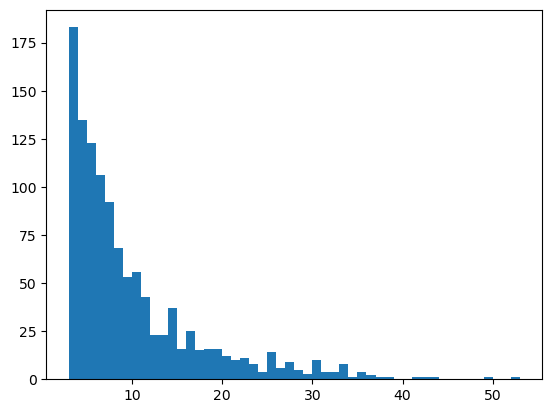

In [229]:
plt.hist([v for k,v in token_counter.items() if len(k)>1],bins=50)

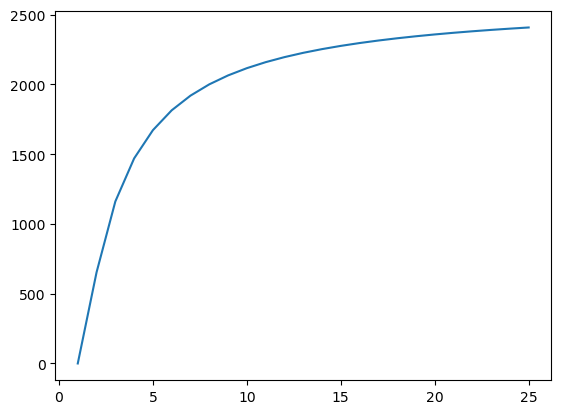

In [279]:
line = np.arange(1,26)
plt.plot(line,(line-1)**2/line**2*2612)

In [308]:
p = 6.538
((line-1)**p/line**p*2612)[24]

2000.1496669613932

In [309]:
(len(example_docs)/6000)//((line-1)**p/line**p*2612)[24]

3.0

In [284]:
3600/128

28.125

In [276]:
len([t for t in token_ranks2 if len(t)==2])

128

In [95]:
tokenize_from_ranks(example_docs[:idx*10000],list(character_counter.keys()))

0.03490424156188965
0.09019112586975098
0.36423683166503906
1.7009329795837402
4.933842897415161
9.130841732025146
14.588897705078125
19.95856738090515
28.979390859603882
37.98038291931152
48.097596406936646
190.85074734687805


In [ ]:
tokens_break = build_token_by_breaking_most_frequent(example_docs[:441])

e  44441 104
 t 31032 105
s  22627 106
d  18646 107
t  15829 108
,  13655 109
er 16238 110
n  11725 111
ou 11920 112
re 10792 113
y  10685 114
an 15576 115
o  9732 116
he 9207 117
he  14699 118
in 14450 119
r  9455 120
en 8461 121
of 9184 122
.  7220 123
ha 8676 124
th 7912 125
 th 9105 126
es 8175 127
of  5962 128
al 6787 129
is 5997 130
is  5462 131
on 8602 132
g  5012 133
ed  4797 134
ar 5253 135
l  3964 136
ee 4092 137
at 5119 138
 w 4259 139
el 3408 140
or 7440 141
at  3562 142
il 4194 143
a  3311 144
er  3214 145
it 4073 146
h  4259 147
e w 2877 148
ea 2724 149
in  3083 150
to  4604 151
the  6263 152
or  3214 153
st 3426 154
es  3125 155
ri 4066 156
om 4776 157
on  3093 158
em 2656 159
im 2959 160
os 2225 161
ec 2112 162
I  2440 163
ac 2520 164
ed 2017 165
en  2267 166
st  2056 167
us 1853 168
us  2835 169
an  2010 170
li 2759 171
ev 2012 172
ow 3669 173
as  2468 174
ent 2303 175
 to  1740 176
be 1738 177
be  1460 178
si 1794 179
re  1442 180
am 2244 181
e,  1705 182
ti 1720 183


In [123]:
[t for t,c in Counter(tokens_break).items() if c>1]

[]

In [124]:
len(tokens_break)

572

In [18]:
example_docs = list(answer_model.docs.values())

In [19]:
len(example_docs)

13671

In [37]:
ord('~')

126

In [32]:
13671/63,13671/441

(217.0, 31.0)

In [44]:
tokens_major = []
for idx in range(0,len(example_docs),21):
    print('-'*20,idx,'-'*20)
    initial_tokens = build_token_rank_list_from_long_frequency(example_docs[idx:idx+21],18,full_word_bias_factor=3,min_frequency=4,min_score=8)
    tokens_major.append(initial_tokens)

-------------------- 0 --------------------
18: 
Final for 18:  0 21 


17: 
Final for 17:  0 21 


16: 
Final for 16:  0 21 


15: 
Final for 15:  0 21 


14: 1 
Final for 14:  1 21 


13: 
Final for 13:  1 21 


12: 
Final for 12:  1 21 


11: 2 3 
Final for 11:  3 21 


10: 4 5 
Final for 10:  5 21 


9: 6 7 8 9 10 
Final for 9:  10 21 


8: 11 12 13 14 
Final for 8:  14 21 


7: 15 16 17 18 19 20 21 22 23 24 
Final for 7:  24 21 


6: 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
Final for 6:  55 21 


5: 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 
Final for 5:  108 21 


4: 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 1

In [68]:
def combine_tokens_from_subsets(subsets):
    distinct_tokens = Counter(reduce(list.__add__,subsets))
    tokens_by_length = [
        list(set([token for token,c in distinct_tokens.items() if (len(token)==length and c>max(1,(10-length))**2)
                         or length==1==len(token)]))

        for length in range(2,19)
        ]
    tokens = reduce(list.__add__,tokens_by_length)[::-1]
    return tokens+list(set(''.join(tokens)))

In [69]:
tokens1 = combine_tokens_from_subsets(tokens_major)

In [70]:
tokens1

['\nAssistant to the ',
 'e Twelve Apostles\n',
 'hers and sisters, ',
 'cil of the Twelve\n',
 '\nOf the Quorum of ',
 'brothers and sist',
 'will manifest it ',
 'Council of the Tw',
 'President Gordon ',
 'Counselor in the ',
 'the First Quorum ',
 'hands; those oppo',
 'Quorum of the Twe',
 'is proposed that ',
 'favor will raise ',
 '\nOf the Council ',
 '\nOf the Seventy\n',
 's of the Church ',
 'Twelve Apostles\n',
 'the kingdom of ',
 'Book of Mormon ',
 'Relief Society ',
 'the priesthood ',
 'of the Seventy\n',
 'Council of the ',
 'the Holy Ghost',
 'of the Twelve\n',
 'the priesthood',
 'of the Church ',
 'of the Twelve ',
 '\nOf the First ',
 'Quorum of the ',
 'missionaries ',
 'Counselor in ',
 'brothers and ',
 'Joseph Smith ',
 'President of ',
 'By President ',
 'and sisters, ',
 'of the Church',
 'Jesus Christ ',
 'First Preside',
 'y President ',
 'opportunity ',
 '\nMy beloved ',
 'the priestho',
 'the Seventy\n',
 'their right ',
 'of the Lord ',
 'the Book of ',

In [71]:
len(tokens1)

1666

In [72]:
tokenized_docs_single = [tokenize_from_ranks(d,[t for t in tokens1 if len(t)==1]) for d in example_docs]
tokenized_docs = [tokenize_from_ranks(d,tokens1) for d in example_docs]

In [73]:
tokenized_docs[0][:20]

['B',
 'ro',
 't',
 'hers and sisters, ',
 'it ',
 'will ',
 'now ',
 'be ',
 'my ',
 'pr',
 'ivi',
 'le',
 'g',
 'e to ',
 'pres',
 'en',
 't the ',
 'General ',
 'A',
 'u']

In [76]:
calc_complexity(tokenized_docs,tokens1),calc_complexity(tokenized_docs_single,list(set([t for t in tokens1 if len(t)==1])))

(108002020.2796721, 199747493.66304952)

In [75]:
1-108002020.2796721/199747493.66304952

0.459307256881737

In [511]:
revised_tokens = full_connect_tokens(initial_tokens,example_docs,min_repeats=2)

In [513]:
revised_tokens2 = full_remove_optimize(revised_tokens,example_docs,135621.59019148987)

135581.0881106379 1 921
135460.33018929523 3 920
135445.4045112019 4 919
135340.5651950677 5 918
135270.97167469165 6 917
135209.33508088885 10 916
135093.11268921965 11 915
135059.8486738814 13 914
134992.45657907537 14 913
134815.99279791332 15 912
134762.16709145275 16 911
134612.92502750855 18 910
134505.72639803137 19 909
134425.7445010363 22 908
134311.68469609492 23 907
134211.21902952553 24 906
134165.18179838068 25 905
134085.0719929976 26 904
133991.3199947319 27 903
133835.1113630851 29 902
133830.9397459514 30 901
133806.30890191003 31 900
133706.8273848773 33 899
133620.9195984755 34 898
133568.97262058582 35 897
133503.39187645732 37 896
133464.95823118265 38 895
133453.65818447497 40 894
133353.9892814738 41 893
133259.88033451163 42 892
133134.20356086624 43 891
133130.73494068248 44 890
133100.05628588158 45 889
133096.4837757179 46 888
133038.5631836023 47 887
133034.89091282416 48 886
132976.8884443579 49 885
132891.71614070307 50 884
132848.42725556192 52 883
132798

In [514]:
tokenized_docs_from_revised = [tokenize_from_ranks(d,revised_tokens2) for d in example_docs]
score_from_revised = calc_complexity(tokenized_docs_from_revised,revised_tokens2)
revised_tokens3 = full_connect_tokens(revised_tokens2,example_docs,min_repeats=2)
tokenized_docs_from_revised2 = [tokenize_from_ranks(d,revised_tokens3) for d in example_docs]
score_from_revised2 = calc_complexity(tokenized_docs_from_revised2,revised_tokens3)
revised_tokens4 = full_remove_optimize(revised_tokens3,example_docs,min(score_from_revised,score_from_revised2))

In [515]:
tokenized_docs2 = [tokenize_from_ranks(d,revised_tokens) for d in example_docs]
tokenized_docs3 = [tokenize_from_ranks(d,revised_tokens2) for d in example_docs]
tokenized_docs4 = [tokenize_from_ranks(d,revised_tokens3) for d in example_docs]
tokenized_docs5 = [tokenize_from_ranks(d,revised_tokens4) for d in example_docs]

In [516]:
(calc_complexity(tokenized_docs_single,[t for t in initial_tokens if len(t)==1]),
 calc_complexity(tokenized_docs,initial_tokens),
 calc_complexity(tokenized_docs2,revised_tokens),
 calc_complexity(tokenized_docs3,revised_tokens2),
 calc_complexity(tokenized_docs4,revised_tokens3),
 calc_complexity(tokenized_docs5,revised_tokens4))

(215832.8464277625,
 135621.59019148987,
 135556.12823054724,
 122793.0121871495,
 122793.0121871495,
 122793.0121871495)

In [520]:
1-calc_complexity(tokenized_docs5,revised_tokens4)/calc_complexity(tokenized_docs_single,[t for t in initial_tokens if len(t)==1])

0.4310735635493399

In [517]:
revised_tokens4

['machine learning ',
 'Machine learning ',
 'deep learning ',
 'organizations ',
 'neural network',
 'intelligence ',
 'scikit-learn ',
 'difficult to ',
 'Data science ',
 'artificial ',
 'supervised ',
 'regression ',
 'prediction ',
 'algorithms ',
 'mathematics',
 'techniques ',
 'technology ',
 'NumPy array',
 'participant',
 'recognition',
 'important ',
 'algorithm ',
 'follow-up ',
 'understand',
 'data point',
 '. However, ',
 'e accurate ',
 'data scien',
 'business ',
 'training ',
 'to build ',
 'possible ',
 'advanced ',
 'patterns ',
 'contains ',
 'neighbors',
 'advantage',
 'the Study',
 'complex ',
 'support ',
 'whether ',
 'improve ',
 'without ',
 'want to ',
 'correct ',
 'between ',
 'customer',
 'structure',
 'classifi',
 'identify',
 'response',
 'platform',
 'of the ',
 ', which ',
 'people ',
 'Python ',
 'models ',
 'require',
 'number ',
 'called ',
 'create ',
 'automat',
 'process',
 'system ',
 'should ',
 'survey ',
 'lication',
 'lgorithm',
 'measure',

In [518]:
[t for t in revised_tokens4 if 10>len(t)>7]

['business ',
 'training ',
 'to build ',
 'possible ',
 'advanced ',
 'patterns ',
 'contains ',
 'neighbors',
 'advantage',
 'the Study',
 'complex ',
 'support ',
 'whether ',
 'improve ',
 'without ',
 'want to ',
 'correct ',
 'between ',
 'customer',
 'structure',
 'classifi',
 'identify',
 'response',
 'platform',
 ', which ',
 'lication',
 'lgorithm',
 'enables ',
 'ogistic ']

In [4]:
class question_answer:
    def __init__(self,embeddings,docs,names,api_key):
        self.embeddings = embeddings
        self.docs = docs
        self.names = names
        self.api_key = api_key
        
    def get_question_embedding(self,question):
        client = cohere.Client(self.api_key)
        q_response = client.embed(
            texts=[question], model="embed-english-v3.0", input_type="search_query"
        )
        return np.array(q_response.embeddings).ravel()
    
    def get_distances(self,q_arr):
        return [cosine(q_arr,d) for d in self.embeddings]
    
    def get_best_indices(self,question,n=5):
        q_arr = self.get_question_embedding(question)
        distances = self.get_distances(q_arr)
        return np.argsort(distances)[:n]
    
    def get_best_doc_names(self,question,n=5):
        best_indices = self.get_best_indices(question,n)
        return [self.names[idx] for idx in best_indices]
    
    def get_best_docs(self,question,n=5):
        best_doc_names = self.get_best_doc_names(question,n)
        return [[name, self.docs[name]] for name in best_doc_names]
    
    def answer_question(self,question,n=5):
        best_docs = self.get_best_docs(question,n)
        for answer in best_docs:
            print(f'{answer[0]}:')
            print(answer[1])
            print('\n\n-------------------------------\n\n')


In [5]:
import pickle

In [6]:
with open('C:/Users/bruce.stoutenburg/Documents/non-project\learn-ds/local_embedding/answerer.pickle','rb') as f:
    answer_model = pickle.load(f)

In [34]:
example_docs = ''.join([d for d in answer_model.docs.values()])
len(example_docs)

47015925

In [35]:
character_counter = Counter(example_docs)
for character,count in character_counter.items():
    if count<1000 and character.lower()==character:
        print(character)
        example_docs = example_docs.replace(character,'')

á
ú
ô
í
ó
ñ
ü
é
―
​
/
 
ç
#
爱
$
â
ã
﻿
ê
ä
ë
½
ö
ﬁ
õ
ž
_
+
ø
à
°
¡
™
è
%
¿
ï
®
©
*
·
=
¢
æ


In [36]:
character_counter = Counter(example_docs)

In [37]:
character_counter['X']

49

' '

In [48]:
character_counter[' ']

8175138